# Disease type classification for disease genes.

## Contents
* [Load gene and disease network.](#Load-gene-and-disease-network)
* [Load the training data.](#Load-the-training-data.)
* [Define-the-training process.](#Define-the-training-process.)
* [Train the classificatrion model.](#Train-the-classificatrion-model.)
* [Eval the results.](#Eval-the-results.)

In [1]:
import sys
import logging
import os
import os.path as osp
import torch
import random
import time
import torch.nn.functional as F
import pandas as pd
from torch.nn import Linear
import numpy as np
from IPython.display import display, HTML
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm
import pickle
import gzip
from livelossplot import PlotLosses
import sklearn

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
##### Expreiment hyperparameters

#  NEGATIVE_SAMPLES determines how the negative examples for training are created.
#  Choose from {'random', 'random_only_disease_gene'}
#    * random: Choose a random (gene, disease) pair which is not in the positive set.
#    * random_only_disease_genes: Like random but gene must be assigned to at least one disease.
NEGATIVE_SAMPLES = 'random'
EXPERIMENT_SLUG = 'final'
device = torch.device('cuda')

## Load gene and disease network

In [3]:
# Define Constants.
HERE = osp.abspath('')
ROOT = osp.join(HERE, '..', '..')
DATA_SOURCE_PATH = osp.join(ROOT, 'data_sources')
GENE_DATASET_ROOT = osp.join(DATA_SOURCE_PATH, 'gene_net_dataset_fn_and_hpo_features')
DISEASE_DATASET_ROOT = osp.join(DATA_SOURCE_PATH, 'disease_net_no_hpo_sim_based')
RESULTS_STORAGE = osp.join(HERE, 'results', EXPERIMENT_SLUG)
MODEL_TMP_STORAGE = osp.join('/', 'var', 'tmp', 'dg_tmp')
sys.path.insert(0, osp.abspath(ROOT))

# Generate the disease and gene network.
from GeneNet import GeneNet
from DiseaseNet import DiseaseNet
from TheModel import TheModel

gene_dataset = GeneNet(
    root=GENE_DATASET_ROOT,
    humannet_version='FN',
    features_to_use='hpo',
    skip_truncated_svd=True
)

disease_dataset = DiseaseNet(
    root=DISEASE_DATASET_ROOT,
    hpo_count_freq_cutoff=40,
    edge_source='feature_similarity',
    feature_source='disease_publications',
    skip_truncated_svd=True,
    svd_components=2048,
    svd_n_iter=12
)
gene_net_data = gene_dataset[0]
disease_net_data = disease_dataset[0]
print(gene_net_data)
print(disease_net_data)
gene_net_data = gene_net_data.to(device)
disease_net_data = disease_net_data.to(device)

Data(edge_attr=[371502, 1], edge_index=[2, 371502], x=[17247, 6209])
Data(edge_attr=[282464], edge_index=[2, 282464], x=[8827, 11460])


## Load the training data.

In [5]:
# Generate training data.
disease_genes = pd.read_table(
    osp.join(DATA_SOURCE_PATH, 'genes_diseases.tsv'),
    names=['EntrezGene ID', 'OMIM ID'],
    sep='\t', 
    low_memory=False, 
    dtype={'EntrezGene ID': pd.Int64Dtype()}
)

disease_id_index_feature_mapping = disease_dataset.load_disease_index_feature_mapping()
gene_id_index_feature_mapping = gene_dataset.load_node_index_mapping()

all_genes = list(gene_id_index_feature_mapping.keys())
all_diseases = list(disease_id_index_feature_mapping.keys())

# 1. generate positive pairs.
# Filter the pairs to only include the ones where the corresponding nodes are available.
# i.e. gene_id should be in all_genes and disease_id should be in all_diseases.
positives = disease_genes[
    disease_genes["OMIM ID"].isin(all_diseases) & disease_genes["EntrezGene ID"].isin(all_genes)
]
covered_diseases = list(set(positives['OMIM ID']))
covered_genes = list(set(positives['EntrezGene ID']))

# 2. Generate negatives.
# Pick equal amount of pairs not in the positives.
negatives_list = []
while len(negatives_list) < len(positives):
    if NEGATIVE_SAMPLES == 'random_only_disease_genes' :
        gene_id = covered_genes[np.random.randint(0, len(covered_genes))]
    else:
        gene_id = all_genes[np.random.randint(0, len(all_genes))]
    disease_id = covered_diseases[np.random.randint(0, len(covered_diseases))]
    if not ((positives['OMIM ID'] == disease_id) & (positives['EntrezGene ID'] == gene_id)).any():
        negatives_list.append([disease_id, gene_id])
negatives = pd.DataFrame(np.array(negatives_list), columns=['OMIM ID', 'EntrezGene ID'])

In [6]:
# Disease classification data preparation.
# Load the disease classes.
GENE_CLASS_LABELS_FILE = osp.join(DATA_SOURCE_PATH, 'extracted_disease_class_assignments.tsv')
# Load the training data
disease_class_training_data = pd.read_csv(GENE_CLASS_LABELS_FILE, sep='\t')
# drop duplicates
unique_labeled_disease_class_genes = disease_class_training_data.drop_duplicates()
gene_id_node_index_df = pd.DataFrame(data=[(gene_id, node_index) for gene_id, node_index in gene_id_index_feature_mapping.items()], columns=['gene_id', 'node_index'])
disease_id_node_index_df = disease_id_node_index_df = pd.DataFrame(
    data=[(disease_id, node_index) for disease_id, node_index in disease_id_index_feature_mapping.items()], columns=['disease_id', 'disease_node_index']
)

# Create the gene index
# Join in the gene node indexes
disease_class_training_data = pd.merge(
    unique_labeled_disease_class_genes, 
    gene_id_node_index_df, 
    left_on='gene_id', 
    right_on='gene_id',
    validate='many_to_many'
)

disease_class_counts = disease_class_training_data['disease_class'].value_counts()
disease_class_target_classes = [
	'Ophthamological',
	'Connective tissue',
	'Endocrine',
	'Skeletal',
	'Metabolic',
	'Cardiovascular',
	'Dermatological',
	'Renal',
	'Hematological',
	'Immunological',
	'Muscular',
	'Developmental'
]


def get_negative_disease_class_data(pos_class, n):
    # n = n // 2
    return disease_class_training_data[disease_class_training_data['disease_class'] != pos_class].sample(n=n, random_state=42)

def get_positive_disease_class_data(pos_class):
    return disease_class_training_data[disease_class_training_data['disease_class'] == pos_class].copy()

def get_disease_class_training_data(pos_class):
    pos = get_positive_disease_class_data(pos_class)
    pos['label'] = 1
    neg = get_negative_disease_class_data(pos_class, len(pos))
    neg['label'] = 0
    data = pd.concat([pos, neg], ignore_index=True)
    x = data.iloc[:,3:].values
    y = data.iloc[:,4:5].values.ravel()
    
    return x, torch.tensor(y), data
disease_class_training_data

,disease_id,gene_id,disease_class,node_index
0,27,1836,Bone,1582
1,160,1836,Connective tissue,1582
2,430,1836,Skeletal,1582
3,496,1836,Bone,1582
4,1,1586,Endocrine,5881
...,...,...,...,...
2673,1615,5195,multiple,9456
2674,1615,5824,multiple,218
2675,1615,5825,multiple,167
2676,1615,9409,multiple,6077


## Define the training process.

In [7]:
model = TheModel(
    gene_feature_dim=gene_net_data.x.shape[1],
    disease_feature_dim=disease_net_data.x.shape[1],
    fc_hidden_dim=3000,
    gene_net_hidden_dim=830,
    disease_net_hidden_dim=500
).to(device)

def train_disease_classification(model_parameter_file):
    # Load the pretrained model.
    model.load_state_dict(torch.load(model_parameter_file))

    # Set classification training hyperparameters.
    lr_classification=0.00000347821
    weight_decay_classification=0.5165618
    folds=5
    max_epochs=100
    info_each_epoch = 1
    early_stopping_window=15
    final_disease_class_metrics = dict()
    losses = {
                    'train': [],
                    'val': [],
                    'AUC': 0,
                    'TPR': None,
                    'FPR': None
            }
    for disease_class in disease_class_target_classes:
        for fold in range(folds):
            losses[f'train_disease_class_{disease_class}_{fold}'] = []
            losses[f'val_disease_class_{disease_class}_{fold}'] = []
            final_disease_class_metrics[f'{disease_class}_{fold}'] = {
                'roc_auc': 0,
                'pr_auc': 0,
                'fmax': 0
            }


    torch.save(model.state_dict(), '/var/tmp/dg_tmp/tmp_model_state.ptm')
    class_count = 0
    for disease_class in disease_class_target_classes:
        class_count += 1
        print(f'Evaluate pretrained model on disease class {disease_class} ({class_count}/{len(disease_class_target_classes)})')
        x_disease_class, y_disease_class, _ = get_disease_class_training_data(disease_class)
        optimizer_disease_class = torch.optim.Adam(model.parameters(), lr=lr_classification, weight_decay=weight_decay_classification)
        criterion_disease_class = torch.nn.CrossEntropyLoss()

        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        fold = -1
        for train_fold_index, test_fold_index in kf.split(x_disease_class):
            fold += 1
            print(f'Starting Fold: {fold}')
            model.load_state_dict(torch.load('/var/tmp/dg_tmp/tmp_model_state.ptm'))
            model.mode = 'Classify'
            # Split into train and validation.
            x_test = x_disease_class[test_fold_index]
            y_test = y_disease_class[test_fold_index].to(device)
            id_tr, id_val = train_test_split(range(x_disease_class[train_fold_index].shape[0]), test_size=0.1, random_state=42)
            x_train = x_disease_class[train_fold_index][id_tr]
            y_train = y_disease_class[train_fold_index][id_tr].to(device)
            x_val = x_disease_class[train_fold_index][id_val]
            y_val = y_disease_class[train_fold_index][id_val].to(device)

            # print(x_test.shape, x_train.shape, x_val.shape)
            # print(y_test.shape, y_train.shape, y_val.shape)

            for epoch in range(max_epochs):
                model.train()

                batch_size = 16
                permutation = torch.randperm(x_train.shape[0])
                # train
                loss_items = []
                for i in range(0, x_train.shape[0], batch_size):
                        # print(f'doing batch {i//batch_size}/{x_train.shape[0]//batch_size}')
                        batch_indices = permutation[i:i+batch_size]
                        batch_x, batch_y = x_train[batch_indices].reshape(-1, 2), y_train[batch_indices]

                        optimizer_disease_class.zero_grad()
                        out = model(gene_net_data, disease_net_data, batch_x)
                        loss = criterion_disease_class(out, batch_y)
                        loss.backward()
                        optimizer_disease_class.step()
                        loss_items.append(loss.item())
                losses[f'train_disease_class_{disease_class}_{fold}'].append(np.mean(loss_items))

                # validation
                with torch.no_grad():
                    model.eval()
                    out = model(gene_net_data, disease_net_data, x_val)
                    loss = criterion_disease_class(out, y_val)
                    losses[f'val_disease_class_{disease_class}_{fold}'].append(loss.item())

                    if epoch % info_each_epoch == 0:
                        print(
                            'Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                                epoch, losses[f'train_disease_class_{disease_class}_{fold}'][epoch], losses[f'val_disease_class_{disease_class}_{fold}'][epoch]
                            )
                        )

                # Early stopping
                if epoch > early_stopping_window:
                    # Stop if validation error did not decrease 
                    # w.r.t. the past early_stopping_window consecutive epochs.
                    last_window_losses = losses[f'val_disease_class_{disease_class}_{fold}'][epoch - early_stopping_window:epoch]
                    if losses[f'val_disease_class_{disease_class}_{fold}'][-1] > max(last_window_losses):
                        print('Early Stopping!')
                        break

            # Test the disease classification model for current fold.
            print(f'Test the model on fold {fold}:')
            with torch.no_grad():
                y_score = model(gene_net_data, disease_net_data, x_test)[:,1].cpu().detach().numpy()
                y = y_test.cpu().detach().numpy()
                final_disease_class_metrics[f'{disease_class}_{fold}']['roc_auc'] = sklearn.metrics.roc_auc_score(y, y_score)
                precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y, y_score)
                final_disease_class_metrics[f'{disease_class}_{fold}']['pr_auc'] = sklearn.metrics.auc(recall, precision)
                final_disease_class_metrics[f'{disease_class}_{fold}']['fmax'] = ((2*precision * recall) / (precision + recall + 0.00001)).max()
                print(final_disease_class_metrics[f'{disease_class}_{fold}'])
    return final_disease_class_metrics

## Train the classificatrion model.
* Run the training for each pretrained model.
* Store results in `disease_classification_results.gz`

In [8]:
import gzip
import pickle

pretrained_folds = 5
all_final_disease_class_metrics = []
results_file = osp.join(RESULTS_STORAGE, f'disease_classification_results.gz')
for i in range(1, pretrained_folds + 1):
    print('############################################################')
    print(f'# START CLASSIFICATION USING PRETRAINED MODEL FROM FOLD: {i} #')
    print('############################################################')
    results = train_disease_classification(osp.join(RESULTS_STORAGE, f'model_fold_{i}.ptm'))
    all_final_disease_class_metrics.append(results)
    with gzip.open(results_file, mode='wb') as f:
        pickle.dump(all_final_disease_class_metrics, f)

############################################################
# START CLASSIFICATION USING PRETRAINED MODEL FROM FOLD: 1 #
############################################################
Evaluate pretrained model on disease class Ophthamological (1/12)
Starting Fold: 0
Epoch 0, train_loss: 0.6949, val_loss: 0.6956
Epoch 1, train_loss: 0.6803, val_loss: 0.6937
Epoch 2, train_loss: 0.6741, val_loss: 0.6877
Epoch 3, train_loss: 0.6623, val_loss: 0.6840
Epoch 4, train_loss: 0.6527, val_loss: 0.6817
Epoch 5, train_loss: 0.6518, val_loss: 0.6765
Epoch 6, train_loss: 0.6384, val_loss: 0.6734
Epoch 7, train_loss: 0.6347, val_loss: 0.6693
Epoch 8, train_loss: 0.6261, val_loss: 0.6625
Epoch 9, train_loss: 0.6247, val_loss: 0.6598
Epoch 10, train_loss: 0.6184, val_loss: 0.6582
Epoch 11, train_loss: 0.6069, val_loss: 0.6544
Epoch 12, train_loss: 0.6068, val_loss: 0.6512
Epoch 13, train_loss: 0.5905, val_loss: 0.6459
Epoch 14, train_loss: 0.5921, val_loss: 0.6417
Epoch 15, train_loss: 0.5803, val_loss:

Epoch 67, train_loss: 0.2193, val_loss: 0.5061
Epoch 68, train_loss: 0.2159, val_loss: 0.5066
Epoch 69, train_loss: 0.2105, val_loss: 0.5069
Epoch 70, train_loss: 0.2139, val_loss: 0.5042
Epoch 71, train_loss: 0.2151, val_loss: 0.5051
Epoch 72, train_loss: 0.2085, val_loss: 0.5054
Epoch 73, train_loss: 0.2045, val_loss: 0.5026
Epoch 74, train_loss: 0.2019, val_loss: 0.5018
Epoch 75, train_loss: 0.1895, val_loss: 0.5011
Epoch 76, train_loss: 0.1874, val_loss: 0.4993
Epoch 77, train_loss: 0.1901, val_loss: 0.5009
Epoch 78, train_loss: 0.1881, val_loss: 0.5035
Epoch 79, train_loss: 0.1831, val_loss: 0.5033
Epoch 80, train_loss: 0.1898, val_loss: 0.5019
Epoch 81, train_loss: 0.1792, val_loss: 0.4986
Epoch 82, train_loss: 0.1879, val_loss: 0.5006
Epoch 83, train_loss: 0.1811, val_loss: 0.5015
Epoch 84, train_loss: 0.1737, val_loss: 0.5020
Epoch 85, train_loss: 0.1770, val_loss: 0.5018
Epoch 86, train_loss: 0.1728, val_loss: 0.4987
Epoch 87, train_loss: 0.1699, val_loss: 0.5007
Epoch 88, tra

Epoch 47, train_loss: 0.2552, val_loss: 0.5770
Epoch 48, train_loss: 0.2506, val_loss: 0.5773
Epoch 49, train_loss: 0.2507, val_loss: 0.5784
Epoch 50, train_loss: 0.2401, val_loss: 0.5779
Epoch 51, train_loss: 0.2423, val_loss: 0.5768
Epoch 52, train_loss: 0.2345, val_loss: 0.5769
Epoch 53, train_loss: 0.2346, val_loss: 0.5748
Epoch 54, train_loss: 0.2274, val_loss: 0.5760
Epoch 55, train_loss: 0.2340, val_loss: 0.5747
Epoch 56, train_loss: 0.2164, val_loss: 0.5752
Epoch 57, train_loss: 0.2281, val_loss: 0.5757
Epoch 58, train_loss: 0.2071, val_loss: 0.5743
Epoch 59, train_loss: 0.2064, val_loss: 0.5733
Epoch 60, train_loss: 0.2088, val_loss: 0.5743
Epoch 61, train_loss: 0.2025, val_loss: 0.5758
Epoch 62, train_loss: 0.2014, val_loss: 0.5780
Epoch 63, train_loss: 0.1991, val_loss: 0.5762
Epoch 64, train_loss: 0.1943, val_loss: 0.5759
Epoch 65, train_loss: 0.1970, val_loss: 0.5738
Epoch 66, train_loss: 0.1882, val_loss: 0.5750
Epoch 67, train_loss: 0.1839, val_loss: 0.5755
Epoch 68, tra

Epoch 39, train_loss: 0.4530, val_loss: 0.6712
Epoch 40, train_loss: 0.4485, val_loss: 0.6706
Epoch 41, train_loss: 0.4564, val_loss: 0.6705
Epoch 42, train_loss: 0.4526, val_loss: 0.6705
Epoch 43, train_loss: 0.4400, val_loss: 0.6708
Epoch 44, train_loss: 0.4334, val_loss: 0.6713
Epoch 45, train_loss: 0.4196, val_loss: 0.6716
Epoch 46, train_loss: 0.4198, val_loss: 0.6711
Epoch 47, train_loss: 0.4137, val_loss: 0.6701
Epoch 48, train_loss: 0.4124, val_loss: 0.6701
Epoch 49, train_loss: 0.4093, val_loss: 0.6693
Epoch 50, train_loss: 0.3932, val_loss: 0.6678
Epoch 51, train_loss: 0.3984, val_loss: 0.6665
Epoch 52, train_loss: 0.3944, val_loss: 0.6656
Epoch 53, train_loss: 0.3912, val_loss: 0.6658
Epoch 54, train_loss: 0.3802, val_loss: 0.6648
Epoch 55, train_loss: 0.3828, val_loss: 0.6641
Epoch 56, train_loss: 0.3680, val_loss: 0.6634
Epoch 57, train_loss: 0.3617, val_loss: 0.6635
Epoch 58, train_loss: 0.3588, val_loss: 0.6635
Epoch 59, train_loss: 0.3524, val_loss: 0.6634
Epoch 60, tra

Epoch 9, train_loss: 0.6579, val_loss: 0.6623
Epoch 10, train_loss: 0.6240, val_loss: 0.6617
Epoch 11, train_loss: 0.6243, val_loss: 0.6612
Epoch 12, train_loss: 0.6176, val_loss: 0.6608
Epoch 13, train_loss: 0.6108, val_loss: 0.6592
Epoch 14, train_loss: 0.5801, val_loss: 0.6581
Epoch 15, train_loss: 0.6009, val_loss: 0.6566
Epoch 16, train_loss: 0.5989, val_loss: 0.6555
Epoch 17, train_loss: 0.6029, val_loss: 0.6544
Epoch 18, train_loss: 0.5912, val_loss: 0.6537
Epoch 19, train_loss: 0.5852, val_loss: 0.6529
Epoch 20, train_loss: 0.5849, val_loss: 0.6519
Epoch 21, train_loss: 0.5824, val_loss: 0.6512
Epoch 22, train_loss: 0.5605, val_loss: 0.6513
Epoch 23, train_loss: 0.5809, val_loss: 0.6504
Epoch 24, train_loss: 0.5523, val_loss: 0.6498
Epoch 25, train_loss: 0.5690, val_loss: 0.6495
Epoch 26, train_loss: 0.5574, val_loss: 0.6493
Epoch 27, train_loss: 0.5455, val_loss: 0.6489
Epoch 28, train_loss: 0.5434, val_loss: 0.6484
Epoch 29, train_loss: 0.5496, val_loss: 0.6481
Epoch 30, trai

Epoch 6, train_loss: 0.6426, val_loss: 0.6520
Epoch 7, train_loss: 0.6298, val_loss: 0.6454
Epoch 8, train_loss: 0.6469, val_loss: 0.6379
Epoch 9, train_loss: 0.6119, val_loss: 0.6323
Epoch 10, train_loss: 0.6245, val_loss: 0.6278
Epoch 11, train_loss: 0.6115, val_loss: 0.6248
Epoch 12, train_loss: 0.6110, val_loss: 0.6214
Epoch 13, train_loss: 0.6087, val_loss: 0.6191
Epoch 14, train_loss: 0.5992, val_loss: 0.6169
Epoch 15, train_loss: 0.6094, val_loss: 0.6138
Epoch 16, train_loss: 0.5717, val_loss: 0.6102
Epoch 17, train_loss: 0.5832, val_loss: 0.6047
Epoch 18, train_loss: 0.5298, val_loss: 0.5992
Epoch 19, train_loss: 0.5656, val_loss: 0.5940
Epoch 20, train_loss: 0.5760, val_loss: 0.5917
Epoch 21, train_loss: 0.5657, val_loss: 0.5881
Epoch 22, train_loss: 0.5486, val_loss: 0.5857
Epoch 23, train_loss: 0.5411, val_loss: 0.5836
Epoch 24, train_loss: 0.5233, val_loss: 0.5819
Epoch 25, train_loss: 0.5536, val_loss: 0.5781
Epoch 26, train_loss: 0.5261, val_loss: 0.5741
Epoch 27, train_l

Epoch 79, train_loss: 0.1899, val_loss: 0.4540
Epoch 80, train_loss: 0.1871, val_loss: 0.4557
Epoch 81, train_loss: 0.1807, val_loss: 0.4565
Epoch 82, train_loss: 0.1788, val_loss: 0.4566
Epoch 83, train_loss: 0.1830, val_loss: 0.4546
Epoch 84, train_loss: 0.1728, val_loss: 0.4609
Epoch 85, train_loss: 0.1733, val_loss: 0.4582
Epoch 86, train_loss: 0.1616, val_loss: 0.4535
Epoch 87, train_loss: 0.1786, val_loss: 0.4515
Epoch 88, train_loss: 0.1661, val_loss: 0.4514
Epoch 89, train_loss: 0.1573, val_loss: 0.4524
Epoch 90, train_loss: 0.1515, val_loss: 0.4502
Epoch 91, train_loss: 0.1601, val_loss: 0.4462
Epoch 92, train_loss: 0.1546, val_loss: 0.4457
Epoch 93, train_loss: 0.1692, val_loss: 0.4442
Epoch 94, train_loss: 0.1549, val_loss: 0.4466
Epoch 95, train_loss: 0.1605, val_loss: 0.4485
Epoch 96, train_loss: 0.1482, val_loss: 0.4503
Epoch 97, train_loss: 0.1400, val_loss: 0.4520
Epoch 98, train_loss: 0.1503, val_loss: 0.4501
Epoch 99, train_loss: 0.1371, val_loss: 0.4493
Test the mode

Epoch 49, train_loss: 0.3405, val_loss: 0.5825
Epoch 50, train_loss: 0.3352, val_loss: 0.5830
Epoch 51, train_loss: 0.3068, val_loss: 0.5814
Epoch 52, train_loss: 0.3147, val_loss: 0.5792
Epoch 53, train_loss: 0.2930, val_loss: 0.5769
Epoch 54, train_loss: 0.3012, val_loss: 0.5749
Epoch 55, train_loss: 0.2937, val_loss: 0.5732
Epoch 56, train_loss: 0.2890, val_loss: 0.5717
Epoch 57, train_loss: 0.2812, val_loss: 0.5700
Epoch 58, train_loss: 0.2817, val_loss: 0.5678
Epoch 59, train_loss: 0.2705, val_loss: 0.5657
Epoch 60, train_loss: 0.2564, val_loss: 0.5630
Epoch 61, train_loss: 0.2446, val_loss: 0.5606
Epoch 62, train_loss: 0.2488, val_loss: 0.5579
Epoch 63, train_loss: 0.2608, val_loss: 0.5562
Epoch 64, train_loss: 0.2268, val_loss: 0.5572
Epoch 65, train_loss: 0.2149, val_loss: 0.5572
Epoch 66, train_loss: 0.2247, val_loss: 0.5544
Epoch 67, train_loss: 0.2335, val_loss: 0.5523
Epoch 68, train_loss: 0.2438, val_loss: 0.5532
Epoch 69, train_loss: 0.2040, val_loss: 0.5511
Epoch 70, tra

Epoch 19, train_loss: 0.5755, val_loss: 0.6109
Epoch 20, train_loss: 0.5698, val_loss: 0.6083
Epoch 21, train_loss: 0.5681, val_loss: 0.6044
Epoch 22, train_loss: 0.5577, val_loss: 0.6002
Epoch 23, train_loss: 0.5448, val_loss: 0.5955
Epoch 24, train_loss: 0.5444, val_loss: 0.5920
Epoch 25, train_loss: 0.5509, val_loss: 0.5899
Epoch 26, train_loss: 0.5294, val_loss: 0.5869
Epoch 27, train_loss: 0.5322, val_loss: 0.5839
Epoch 28, train_loss: 0.5148, val_loss: 0.5800
Epoch 29, train_loss: 0.5199, val_loss: 0.5743
Epoch 30, train_loss: 0.5104, val_loss: 0.5699
Epoch 31, train_loss: 0.4916, val_loss: 0.5656
Epoch 32, train_loss: 0.4891, val_loss: 0.5601
Epoch 33, train_loss: 0.4647, val_loss: 0.5563
Epoch 34, train_loss: 0.4710, val_loss: 0.5521
Epoch 35, train_loss: 0.4650, val_loss: 0.5466
Epoch 36, train_loss: 0.4689, val_loss: 0.5440
Epoch 37, train_loss: 0.4494, val_loss: 0.5392
Epoch 38, train_loss: 0.4435, val_loss: 0.5338
Epoch 39, train_loss: 0.4235, val_loss: 0.5289
Epoch 40, tra

Epoch 35, train_loss: 0.4340, val_loss: 0.4821
Epoch 36, train_loss: 0.4222, val_loss: 0.4780
Epoch 37, train_loss: 0.4094, val_loss: 0.4760
Epoch 38, train_loss: 0.4146, val_loss: 0.4725
Epoch 39, train_loss: 0.4024, val_loss: 0.4684
Epoch 40, train_loss: 0.3971, val_loss: 0.4643
Epoch 41, train_loss: 0.3904, val_loss: 0.4607
Epoch 42, train_loss: 0.3867, val_loss: 0.4574
Epoch 43, train_loss: 0.3840, val_loss: 0.4535
Epoch 44, train_loss: 0.3685, val_loss: 0.4489
Epoch 45, train_loss: 0.3701, val_loss: 0.4451
Epoch 46, train_loss: 0.3709, val_loss: 0.4428
Epoch 47, train_loss: 0.3604, val_loss: 0.4423
Epoch 48, train_loss: 0.3515, val_loss: 0.4422
Epoch 49, train_loss: 0.3469, val_loss: 0.4411
Epoch 50, train_loss: 0.3494, val_loss: 0.4399
Epoch 51, train_loss: 0.3386, val_loss: 0.4376
Epoch 52, train_loss: 0.3389, val_loss: 0.4357
Epoch 53, train_loss: 0.3240, val_loss: 0.4327
Epoch 54, train_loss: 0.3230, val_loss: 0.4287
Epoch 55, train_loss: 0.3111, val_loss: 0.4268
Epoch 56, tra

Epoch 38, train_loss: 0.3851, val_loss: 0.4925
Epoch 39, train_loss: 0.3843, val_loss: 0.4894
Epoch 40, train_loss: 0.3717, val_loss: 0.4859
Epoch 41, train_loss: 0.3721, val_loss: 0.4826
Epoch 42, train_loss: 0.3678, val_loss: 0.4791
Epoch 43, train_loss: 0.3655, val_loss: 0.4751
Epoch 44, train_loss: 0.3544, val_loss: 0.4715
Epoch 45, train_loss: 0.3522, val_loss: 0.4680
Epoch 46, train_loss: 0.3475, val_loss: 0.4646
Epoch 47, train_loss: 0.3374, val_loss: 0.4614
Epoch 48, train_loss: 0.3351, val_loss: 0.4579
Epoch 49, train_loss: 0.3332, val_loss: 0.4549
Epoch 50, train_loss: 0.3291, val_loss: 0.4520
Epoch 51, train_loss: 0.3219, val_loss: 0.4487
Epoch 52, train_loss: 0.3162, val_loss: 0.4458
Epoch 53, train_loss: 0.3114, val_loss: 0.4429
Epoch 54, train_loss: 0.3048, val_loss: 0.4406
Epoch 55, train_loss: 0.2978, val_loss: 0.4377
Epoch 56, train_loss: 0.2990, val_loss: 0.4349
Epoch 57, train_loss: 0.2940, val_loss: 0.4316
Epoch 58, train_loss: 0.2885, val_loss: 0.4287
Epoch 59, tra

Epoch 16, train_loss: 0.4936, val_loss: 0.4851
Epoch 17, train_loss: 0.4855, val_loss: 0.4771
Epoch 18, train_loss: 0.4657, val_loss: 0.4673
Epoch 19, train_loss: 0.4553, val_loss: 0.4568
Epoch 20, train_loss: 0.4420, val_loss: 0.4460
Epoch 21, train_loss: 0.4257, val_loss: 0.4384
Epoch 22, train_loss: 0.4136, val_loss: 0.4270
Epoch 23, train_loss: 0.3953, val_loss: 0.4197
Epoch 24, train_loss: 0.3798, val_loss: 0.4118
Epoch 25, train_loss: 0.3725, val_loss: 0.4064
Epoch 26, train_loss: 0.3592, val_loss: 0.3977
Epoch 27, train_loss: 0.3366, val_loss: 0.3970
Epoch 28, train_loss: 0.3371, val_loss: 0.3880
Epoch 29, train_loss: 0.3235, val_loss: 0.3857
Epoch 30, train_loss: 0.3183, val_loss: 0.3789
Epoch 31, train_loss: 0.3055, val_loss: 0.3741
Epoch 32, train_loss: 0.2913, val_loss: 0.3714
Epoch 33, train_loss: 0.2865, val_loss: 0.3691
Epoch 34, train_loss: 0.2752, val_loss: 0.3669
Epoch 35, train_loss: 0.2672, val_loss: 0.3683
Epoch 36, train_loss: 0.2555, val_loss: 0.3631
Epoch 37, tra

Epoch 8, train_loss: 0.5825, val_loss: 0.5721
Epoch 9, train_loss: 0.5732, val_loss: 0.5621
Epoch 10, train_loss: 0.5584, val_loss: 0.5520
Epoch 11, train_loss: 0.5484, val_loss: 0.5389
Epoch 12, train_loss: 0.5400, val_loss: 0.5276
Epoch 13, train_loss: 0.5198, val_loss: 0.5188
Epoch 14, train_loss: 0.5148, val_loss: 0.5079
Epoch 15, train_loss: 0.4968, val_loss: 0.4996
Epoch 16, train_loss: 0.4788, val_loss: 0.4893
Epoch 17, train_loss: 0.4686, val_loss: 0.4802
Epoch 18, train_loss: 0.4518, val_loss: 0.4713
Epoch 19, train_loss: 0.4399, val_loss: 0.4646
Epoch 20, train_loss: 0.4226, val_loss: 0.4552
Epoch 21, train_loss: 0.4067, val_loss: 0.4485
Epoch 22, train_loss: 0.3878, val_loss: 0.4422
Epoch 23, train_loss: 0.3775, val_loss: 0.4353
Epoch 24, train_loss: 0.3718, val_loss: 0.4288
Epoch 25, train_loss: 0.3525, val_loss: 0.4261
Epoch 26, train_loss: 0.3427, val_loss: 0.4214
Epoch 27, train_loss: 0.3271, val_loss: 0.4156
Epoch 28, train_loss: 0.3198, val_loss: 0.4151
Epoch 29, train

Epoch 0, train_loss: 0.6980, val_loss: 0.6919
Epoch 1, train_loss: 0.6827, val_loss: 0.6852
Epoch 2, train_loss: 0.6785, val_loss: 0.6794
Epoch 3, train_loss: 0.6683, val_loss: 0.6759
Epoch 4, train_loss: 0.6574, val_loss: 0.6727
Epoch 5, train_loss: 0.6534, val_loss: 0.6718
Epoch 6, train_loss: 0.6415, val_loss: 0.6684
Epoch 7, train_loss: 0.6445, val_loss: 0.6683
Epoch 8, train_loss: 0.6361, val_loss: 0.6664
Epoch 9, train_loss: 0.6276, val_loss: 0.6644
Epoch 10, train_loss: 0.6260, val_loss: 0.6629
Epoch 11, train_loss: 0.6236, val_loss: 0.6618
Epoch 12, train_loss: 0.6163, val_loss: 0.6583
Epoch 13, train_loss: 0.6123, val_loss: 0.6569
Epoch 14, train_loss: 0.6045, val_loss: 0.6556
Epoch 15, train_loss: 0.6016, val_loss: 0.6536
Epoch 16, train_loss: 0.5998, val_loss: 0.6522
Epoch 17, train_loss: 0.5938, val_loss: 0.6518
Epoch 18, train_loss: 0.5848, val_loss: 0.6505
Epoch 19, train_loss: 0.5803, val_loss: 0.6494
Epoch 20, train_loss: 0.5743, val_loss: 0.6490
Epoch 21, train_loss: 0

Epoch 52, train_loss: 0.2962, val_loss: 0.4440
Epoch 53, train_loss: 0.2818, val_loss: 0.4409
Epoch 54, train_loss: 0.2753, val_loss: 0.4374
Epoch 55, train_loss: 0.2692, val_loss: 0.4348
Epoch 56, train_loss: 0.2499, val_loss: 0.4334
Epoch 57, train_loss: 0.2438, val_loss: 0.4322
Epoch 58, train_loss: 0.2516, val_loss: 0.4319
Epoch 59, train_loss: 0.2415, val_loss: 0.4301
Epoch 60, train_loss: 0.2429, val_loss: 0.4286
Epoch 61, train_loss: 0.2240, val_loss: 0.4263
Epoch 62, train_loss: 0.2587, val_loss: 0.4253
Epoch 63, train_loss: 0.2131, val_loss: 0.4243
Epoch 64, train_loss: 0.2193, val_loss: 0.4208
Epoch 65, train_loss: 0.2074, val_loss: 0.4199
Epoch 66, train_loss: 0.2128, val_loss: 0.4184
Epoch 67, train_loss: 0.2117, val_loss: 0.4172
Epoch 68, train_loss: 0.2369, val_loss: 0.4172
Epoch 69, train_loss: 0.1984, val_loss: 0.4165
Epoch 70, train_loss: 0.1939, val_loss: 0.4164
Epoch 71, train_loss: 0.1892, val_loss: 0.4151
Epoch 72, train_loss: 0.1917, val_loss: 0.4145
Epoch 73, tra

Epoch 22, train_loss: 0.5001, val_loss: 0.5475
Epoch 23, train_loss: 0.4868, val_loss: 0.5441
Epoch 24, train_loss: 0.4766, val_loss: 0.5414
Epoch 25, train_loss: 0.4864, val_loss: 0.5378
Epoch 26, train_loss: 0.4621, val_loss: 0.5338
Epoch 27, train_loss: 0.4627, val_loss: 0.5308
Epoch 28, train_loss: 0.4647, val_loss: 0.5277
Epoch 29, train_loss: 0.4618, val_loss: 0.5252
Epoch 30, train_loss: 0.4505, val_loss: 0.5217
Epoch 31, train_loss: 0.4336, val_loss: 0.5184
Epoch 32, train_loss: 0.4196, val_loss: 0.5153
Epoch 33, train_loss: 0.4340, val_loss: 0.5114
Epoch 34, train_loss: 0.4061, val_loss: 0.5092
Epoch 35, train_loss: 0.3981, val_loss: 0.5059
Epoch 36, train_loss: 0.4050, val_loss: 0.5029
Epoch 37, train_loss: 0.3818, val_loss: 0.5001
Epoch 38, train_loss: 0.3901, val_loss: 0.4982
Epoch 39, train_loss: 0.3885, val_loss: 0.4932
Epoch 40, train_loss: 0.3739, val_loss: 0.4917
Epoch 41, train_loss: 0.3832, val_loss: 0.4893
Epoch 42, train_loss: 0.3463, val_loss: 0.4872
Epoch 43, tra

Epoch 25, train_loss: 0.5039, val_loss: 0.5675
Epoch 26, train_loss: 0.4943, val_loss: 0.5645
Epoch 27, train_loss: 0.4825, val_loss: 0.5612
Epoch 28, train_loss: 0.4831, val_loss: 0.5576
Epoch 29, train_loss: 0.4887, val_loss: 0.5537
Epoch 30, train_loss: 0.4819, val_loss: 0.5505
Epoch 31, train_loss: 0.4711, val_loss: 0.5475
Epoch 32, train_loss: 0.4603, val_loss: 0.5445
Epoch 33, train_loss: 0.4442, val_loss: 0.5411
Epoch 34, train_loss: 0.4431, val_loss: 0.5378
Epoch 35, train_loss: 0.4400, val_loss: 0.5348
Epoch 36, train_loss: 0.4333, val_loss: 0.5317
Epoch 37, train_loss: 0.4200, val_loss: 0.5286
Epoch 38, train_loss: 0.3964, val_loss: 0.5252
Epoch 39, train_loss: 0.4075, val_loss: 0.5229
Epoch 40, train_loss: 0.4096, val_loss: 0.5203
Epoch 41, train_loss: 0.3969, val_loss: 0.5178
Epoch 42, train_loss: 0.3869, val_loss: 0.5152
Epoch 43, train_loss: 0.3738, val_loss: 0.5124
Epoch 44, train_loss: 0.3866, val_loss: 0.5101
Epoch 45, train_loss: 0.3734, val_loss: 0.5076
Epoch 46, tra

Epoch 98, train_loss: 0.2193, val_loss: 0.5964
Epoch 99, train_loss: 0.2174, val_loss: 0.5964
Test the model on fold 0:
{'roc_auc': 0.7592592592592593, 'pr_auc': 0.8657285107401766, 'fmax': 0.8571379592116616}
Starting Fold: 1
Epoch 0, train_loss: 0.6904, val_loss: 0.6863
Epoch 1, train_loss: 0.6863, val_loss: 0.6805
Epoch 2, train_loss: 0.6736, val_loss: 0.6726
Epoch 3, train_loss: 0.6696, val_loss: 0.6650
Epoch 4, train_loss: 0.6681, val_loss: 0.6604
Epoch 5, train_loss: 0.6593, val_loss: 0.6563
Epoch 6, train_loss: 0.6521, val_loss: 0.6520
Epoch 7, train_loss: 0.6493, val_loss: 0.6494
Epoch 8, train_loss: 0.6417, val_loss: 0.6477
Epoch 9, train_loss: 0.6303, val_loss: 0.6452
Epoch 10, train_loss: 0.6380, val_loss: 0.6429
Epoch 11, train_loss: 0.6291, val_loss: 0.6408
Epoch 12, train_loss: 0.6177, val_loss: 0.6377
Epoch 13, train_loss: 0.6190, val_loss: 0.6345
Epoch 14, train_loss: 0.6106, val_loss: 0.6320
Epoch 15, train_loss: 0.6117, val_loss: 0.6306
Epoch 16, train_loss: 0.6084, v

Epoch 68, train_loss: 0.3550, val_loss: 0.6758
Epoch 69, train_loss: 0.3553, val_loss: 0.6751
Epoch 70, train_loss: 0.3455, val_loss: 0.6754
Epoch 71, train_loss: 0.3466, val_loss: 0.6749
Epoch 72, train_loss: 0.3379, val_loss: 0.6748
Epoch 73, train_loss: 0.3450, val_loss: 0.6741
Epoch 74, train_loss: 0.3225, val_loss: 0.6732
Epoch 75, train_loss: 0.3252, val_loss: 0.6727
Epoch 76, train_loss: 0.3262, val_loss: 0.6723
Epoch 77, train_loss: 0.3144, val_loss: 0.6717
Epoch 78, train_loss: 0.3107, val_loss: 0.6707
Epoch 79, train_loss: 0.3126, val_loss: 0.6708
Epoch 80, train_loss: 0.3014, val_loss: 0.6715
Epoch 81, train_loss: 0.3040, val_loss: 0.6713
Epoch 82, train_loss: 0.2922, val_loss: 0.6713
Epoch 83, train_loss: 0.2913, val_loss: 0.6701
Epoch 84, train_loss: 0.2892, val_loss: 0.6697
Epoch 85, train_loss: 0.2874, val_loss: 0.6693
Epoch 86, train_loss: 0.2822, val_loss: 0.6684
Epoch 87, train_loss: 0.2704, val_loss: 0.6688
Epoch 88, train_loss: 0.2807, val_loss: 0.6681
Epoch 89, tra

Epoch 90, train_loss: 0.2608, val_loss: 0.5728
Epoch 91, train_loss: 0.2564, val_loss: 0.5719
Epoch 92, train_loss: 0.2456, val_loss: 0.5709
Epoch 93, train_loss: 0.2459, val_loss: 0.5691
Epoch 94, train_loss: 0.2415, val_loss: 0.5683
Epoch 95, train_loss: 0.2344, val_loss: 0.5684
Epoch 96, train_loss: 0.2422, val_loss: 0.5675
Epoch 97, train_loss: 0.2347, val_loss: 0.5662
Epoch 98, train_loss: 0.2331, val_loss: 0.5652
Epoch 99, train_loss: 0.2281, val_loss: 0.5644
Test the model on fold 4:
{'roc_auc': 0.675, 'pr_auc': 0.7033508991008991, 'fmax': 0.6363586777245892}
Evaluate pretrained model on disease class Hematological (9/12)
Starting Fold: 0
Epoch 0, train_loss: 0.6899, val_loss: 0.6797
Epoch 1, train_loss: 0.6791, val_loss: 0.6699
Epoch 2, train_loss: 0.6697, val_loss: 0.6598
Epoch 3, train_loss: 0.6543, val_loss: 0.6500
Epoch 4, train_loss: 0.6489, val_loss: 0.6406
Epoch 5, train_loss: 0.6350, val_loss: 0.6307
Epoch 6, train_loss: 0.6290, val_loss: 0.6216
Epoch 7, train_loss: 0.6

Epoch 22, train_loss: 0.4737, val_loss: 0.6040
Epoch 23, train_loss: 0.4652, val_loss: 0.6015
Epoch 24, train_loss: 0.4595, val_loss: 0.6004
Epoch 25, train_loss: 0.4506, val_loss: 0.5984
Epoch 26, train_loss: 0.4390, val_loss: 0.5960
Epoch 27, train_loss: 0.4386, val_loss: 0.5924
Epoch 28, train_loss: 0.4254, val_loss: 0.5893
Epoch 29, train_loss: 0.4200, val_loss: 0.5889
Epoch 30, train_loss: 0.4132, val_loss: 0.5865
Epoch 31, train_loss: 0.4013, val_loss: 0.5844
Epoch 32, train_loss: 0.3978, val_loss: 0.5810
Epoch 33, train_loss: 0.3879, val_loss: 0.5803
Epoch 34, train_loss: 0.3796, val_loss: 0.5792
Epoch 35, train_loss: 0.3739, val_loss: 0.5768
Epoch 36, train_loss: 0.3621, val_loss: 0.5741
Epoch 37, train_loss: 0.3591, val_loss: 0.5718
Epoch 38, train_loss: 0.3506, val_loss: 0.5702
Epoch 39, train_loss: 0.3434, val_loss: 0.5671
Epoch 40, train_loss: 0.3364, val_loss: 0.5656
Epoch 41, train_loss: 0.3283, val_loss: 0.5645
Epoch 42, train_loss: 0.3220, val_loss: 0.5606
Epoch 43, tra

Epoch 33, train_loss: 0.3594, val_loss: 0.5158
Epoch 34, train_loss: 0.3503, val_loss: 0.5137
Epoch 35, train_loss: 0.3426, val_loss: 0.5125
Epoch 36, train_loss: 0.3322, val_loss: 0.5103
Epoch 37, train_loss: 0.3275, val_loss: 0.5091
Epoch 38, train_loss: 0.3134, val_loss: 0.5066
Epoch 39, train_loss: 0.3133, val_loss: 0.5051
Epoch 40, train_loss: 0.3062, val_loss: 0.5040
Epoch 41, train_loss: 0.2977, val_loss: 0.5043
Epoch 42, train_loss: 0.2958, val_loss: 0.5017
Epoch 43, train_loss: 0.2835, val_loss: 0.5022
Epoch 44, train_loss: 0.2812, val_loss: 0.5018
Epoch 45, train_loss: 0.2760, val_loss: 0.5005
Epoch 46, train_loss: 0.2661, val_loss: 0.4990
Epoch 47, train_loss: 0.2638, val_loss: 0.4990
Epoch 48, train_loss: 0.2555, val_loss: 0.4978
Epoch 49, train_loss: 0.2465, val_loss: 0.4980
Epoch 50, train_loss: 0.2466, val_loss: 0.4989
Epoch 51, train_loss: 0.2386, val_loss: 0.4995
Epoch 52, train_loss: 0.2307, val_loss: 0.4973
Epoch 53, train_loss: 0.2335, val_loss: 0.4992
Epoch 54, tra

Epoch 38, train_loss: 0.3457, val_loss: 0.5936
Epoch 39, train_loss: 0.3347, val_loss: 0.5882
Epoch 40, train_loss: 0.3319, val_loss: 0.5921
Epoch 41, train_loss: 0.3302, val_loss: 0.5910
Epoch 42, train_loss: 0.3286, val_loss: 0.5890
Epoch 43, train_loss: 0.3188, val_loss: 0.5913
Epoch 44, train_loss: 0.3077, val_loss: 0.5932
Epoch 45, train_loss: 0.3072, val_loss: 0.5938
Epoch 46, train_loss: 0.2950, val_loss: 0.5893
Epoch 47, train_loss: 0.2865, val_loss: 0.5929
Epoch 48, train_loss: 0.2894, val_loss: 0.5923
Epoch 49, train_loss: 0.2811, val_loss: 0.5941
Epoch 50, train_loss: 0.2744, val_loss: 0.5966
Epoch 51, train_loss: 0.2681, val_loss: 0.5877
Epoch 52, train_loss: 0.2787, val_loss: 0.5936
Epoch 53, train_loss: 0.2570, val_loss: 0.5973
Early Stopping!
Test the model on fold 1:
{'roc_auc': 0.8967741935483872, 'pr_auc': 0.9480164841936759, 'fmax': 0.8852409030112945}
Starting Fold: 2
Epoch 0, train_loss: 0.6929, val_loss: 0.6843
Epoch 1, train_loss: 0.6714, val_loss: 0.6780
Epoch 2

Epoch 70, train_loss: 0.2113, val_loss: 0.4536
Epoch 71, train_loss: 0.2013, val_loss: 0.4537
Epoch 72, train_loss: 0.1981, val_loss: 0.4512
Epoch 73, train_loss: 0.2129, val_loss: 0.4520
Epoch 74, train_loss: 0.1979, val_loss: 0.4506
Epoch 75, train_loss: 0.1965, val_loss: 0.4478
Epoch 76, train_loss: 0.1977, val_loss: 0.4487
Epoch 77, train_loss: 0.1880, val_loss: 0.4442
Epoch 78, train_loss: 0.1935, val_loss: 0.4465
Epoch 79, train_loss: 0.1908, val_loss: 0.4437
Epoch 80, train_loss: 0.1836, val_loss: 0.4457
Epoch 81, train_loss: 0.1878, val_loss: 0.4499
Epoch 82, train_loss: 0.1801, val_loss: 0.4432
Epoch 83, train_loss: 0.1760, val_loss: 0.4409
Epoch 84, train_loss: 0.1830, val_loss: 0.4415
Epoch 85, train_loss: 0.1758, val_loss: 0.4446
Epoch 86, train_loss: 0.1733, val_loss: 0.4446
Epoch 87, train_loss: 0.1706, val_loss: 0.4428
Epoch 88, train_loss: 0.1736, val_loss: 0.4411
Epoch 89, train_loss: 0.1692, val_loss: 0.4414
Epoch 90, train_loss: 0.1704, val_loss: 0.4384
Epoch 91, tra

Epoch 77, train_loss: 0.2345, val_loss: 0.4463
Epoch 78, train_loss: 0.2317, val_loss: 0.4447
Epoch 79, train_loss: 0.2193, val_loss: 0.4438
Epoch 80, train_loss: 0.2173, val_loss: 0.4417
Epoch 81, train_loss: 0.2147, val_loss: 0.4405
Epoch 82, train_loss: 0.2120, val_loss: 0.4395
Epoch 83, train_loss: 0.2131, val_loss: 0.4373
Epoch 84, train_loss: 0.2131, val_loss: 0.4353
Epoch 85, train_loss: 0.2017, val_loss: 0.4350
Epoch 86, train_loss: 0.1980, val_loss: 0.4343
Epoch 87, train_loss: 0.1959, val_loss: 0.4335
Epoch 88, train_loss: 0.1992, val_loss: 0.4314
Epoch 89, train_loss: 0.1963, val_loss: 0.4301
Epoch 90, train_loss: 0.1961, val_loss: 0.4295
Epoch 91, train_loss: 0.1933, val_loss: 0.4288
Epoch 92, train_loss: 0.1885, val_loss: 0.4281
Epoch 93, train_loss: 0.1947, val_loss: 0.4261
Epoch 94, train_loss: 0.1924, val_loss: 0.4246
Epoch 95, train_loss: 0.1885, val_loss: 0.4244
Epoch 96, train_loss: 0.1947, val_loss: 0.4238
Epoch 97, train_loss: 0.1764, val_loss: 0.4228
Epoch 98, tra

Epoch 47, train_loss: 0.3735, val_loss: 0.4266
Epoch 48, train_loss: 0.3780, val_loss: 0.4251
Epoch 49, train_loss: 0.3635, val_loss: 0.4237
Epoch 50, train_loss: 0.3558, val_loss: 0.4229
Epoch 51, train_loss: 0.3565, val_loss: 0.4208
Epoch 52, train_loss: 0.3530, val_loss: 0.4191
Epoch 53, train_loss: 0.3494, val_loss: 0.4185
Epoch 54, train_loss: 0.3388, val_loss: 0.4168
Epoch 55, train_loss: 0.3375, val_loss: 0.4146
Epoch 56, train_loss: 0.3257, val_loss: 0.4119
Epoch 57, train_loss: 0.3325, val_loss: 0.4100
Epoch 58, train_loss: 0.3143, val_loss: 0.4091
Epoch 59, train_loss: 0.3061, val_loss: 0.4075
Epoch 60, train_loss: 0.3016, val_loss: 0.4057
Epoch 61, train_loss: 0.3023, val_loss: 0.4035
Epoch 62, train_loss: 0.2919, val_loss: 0.4015
Epoch 63, train_loss: 0.2859, val_loss: 0.4014
Epoch 64, train_loss: 0.2806, val_loss: 0.4001
Epoch 65, train_loss: 0.2731, val_loss: 0.3983
Epoch 66, train_loss: 0.2716, val_loss: 0.3982
Epoch 67, train_loss: 0.2651, val_loss: 0.3968
Epoch 68, tra

Epoch 17, train_loss: 0.5459, val_loss: 0.5114
Epoch 18, train_loss: 0.5336, val_loss: 0.5081
Epoch 19, train_loss: 0.5332, val_loss: 0.5027
Epoch 20, train_loss: 0.5323, val_loss: 0.4980
Epoch 21, train_loss: 0.5321, val_loss: 0.4931
Epoch 22, train_loss: 0.5148, val_loss: 0.4912
Epoch 23, train_loss: 0.5027, val_loss: 0.4901
Epoch 24, train_loss: 0.4932, val_loss: 0.4890
Epoch 25, train_loss: 0.5074, val_loss: 0.4853
Epoch 26, train_loss: 0.4941, val_loss: 0.4820
Epoch 27, train_loss: 0.4842, val_loss: 0.4776
Epoch 28, train_loss: 0.4766, val_loss: 0.4736
Epoch 29, train_loss: 0.4749, val_loss: 0.4708
Epoch 30, train_loss: 0.4708, val_loss: 0.4706
Epoch 31, train_loss: 0.4721, val_loss: 0.4686
Epoch 32, train_loss: 0.4532, val_loss: 0.4669
Epoch 33, train_loss: 0.4447, val_loss: 0.4640
Epoch 34, train_loss: 0.4462, val_loss: 0.4605
Epoch 35, train_loss: 0.4443, val_loss: 0.4576
Epoch 36, train_loss: 0.4370, val_loss: 0.4555
Epoch 37, train_loss: 0.4228, val_loss: 0.4542
Epoch 38, tra

Epoch 88, train_loss: 0.2815, val_loss: 0.5436
Epoch 89, train_loss: 0.2752, val_loss: 0.5418
Epoch 90, train_loss: 0.2394, val_loss: 0.5407
Epoch 91, train_loss: 0.2673, val_loss: 0.5399
Epoch 92, train_loss: 0.2672, val_loss: 0.5393
Epoch 93, train_loss: 0.2556, val_loss: 0.5389
Epoch 94, train_loss: 0.2344, val_loss: 0.5379
Epoch 95, train_loss: 0.2591, val_loss: 0.5375
Epoch 96, train_loss: 0.2354, val_loss: 0.5372
Epoch 97, train_loss: 0.2148, val_loss: 0.5359
Epoch 98, train_loss: 0.2206, val_loss: 0.5345
Epoch 99, train_loss: 0.2355, val_loss: 0.5331
Test the model on fold 0:
{'roc_auc': 0.7651515151515151, 'pr_auc': 0.7988982529886423, 'fmax': 0.8333283333633332}
Starting Fold: 1
Epoch 0, train_loss: 0.7008, val_loss: 0.6969
Epoch 1, train_loss: 0.6712, val_loss: 0.6957
Epoch 2, train_loss: 0.6863, val_loss: 0.6936
Epoch 3, train_loss: 0.6851, val_loss: 0.6926
Epoch 4, train_loss: 0.6500, val_loss: 0.6926
Epoch 5, train_loss: 0.6713, val_loss: 0.6929
Epoch 6, train_loss: 0.6481

Epoch 37, train_loss: 0.5043, val_loss: 0.5971
Epoch 38, train_loss: 0.5108, val_loss: 0.5954
Epoch 39, train_loss: 0.5284, val_loss: 0.5911
Epoch 40, train_loss: 0.4666, val_loss: 0.5884
Epoch 41, train_loss: 0.4672, val_loss: 0.5862
Epoch 42, train_loss: 0.5269, val_loss: 0.5841
Epoch 43, train_loss: 0.5240, val_loss: 0.5842
Epoch 44, train_loss: 0.5117, val_loss: 0.5844
Epoch 45, train_loss: 0.4534, val_loss: 0.5838
Epoch 46, train_loss: 0.4233, val_loss: 0.5818
Epoch 47, train_loss: 0.4908, val_loss: 0.5798
Epoch 48, train_loss: 0.4285, val_loss: 0.5775
Epoch 49, train_loss: 0.5086, val_loss: 0.5752
Epoch 50, train_loss: 0.4814, val_loss: 0.5740
Epoch 51, train_loss: 0.4393, val_loss: 0.5727
Epoch 52, train_loss: 0.4192, val_loss: 0.5714
Epoch 53, train_loss: 0.4974, val_loss: 0.5711
Epoch 54, train_loss: 0.4129, val_loss: 0.5708
Epoch 55, train_loss: 0.4216, val_loss: 0.5701
Epoch 56, train_loss: 0.4471, val_loss: 0.5683
Epoch 57, train_loss: 0.5132, val_loss: 0.5662
Epoch 58, tra

Epoch 82, train_loss: 0.1936, val_loss: 0.4486
Epoch 83, train_loss: 0.1936, val_loss: 0.4488
Epoch 84, train_loss: 0.1808, val_loss: 0.4471
Epoch 85, train_loss: 0.1937, val_loss: 0.4491
Epoch 86, train_loss: 0.1913, val_loss: 0.4500
Epoch 87, train_loss: 0.1834, val_loss: 0.4482
Epoch 88, train_loss: 0.1822, val_loss: 0.4501
Epoch 89, train_loss: 0.1744, val_loss: 0.4518
Epoch 90, train_loss: 0.1775, val_loss: 0.4472
Epoch 91, train_loss: 0.1685, val_loss: 0.4462
Epoch 92, train_loss: 0.1726, val_loss: 0.4426
Epoch 93, train_loss: 0.1757, val_loss: 0.4478
Epoch 94, train_loss: 0.1694, val_loss: 0.4497
Epoch 95, train_loss: 0.1734, val_loss: 0.4505
Epoch 96, train_loss: 0.1735, val_loss: 0.4489
Epoch 97, train_loss: 0.1632, val_loss: 0.4477
Epoch 98, train_loss: 0.1671, val_loss: 0.4424
Epoch 99, train_loss: 0.1697, val_loss: 0.4449
Test the model on fold 0:
{'roc_auc': 0.892361111111111, 'pr_auc': 0.931035258752252, 'fmax': 0.8571379592116616}
Starting Fold: 1
Epoch 0, train_loss: 0.

Epoch 52, train_loss: 0.2764, val_loss: 0.5593
Epoch 53, train_loss: 0.2806, val_loss: 0.5587
Epoch 54, train_loss: 0.2730, val_loss: 0.5572
Epoch 55, train_loss: 0.2716, val_loss: 0.5553
Epoch 56, train_loss: 0.2537, val_loss: 0.5530
Epoch 57, train_loss: 0.2559, val_loss: 0.5530
Epoch 58, train_loss: 0.2457, val_loss: 0.5518
Epoch 59, train_loss: 0.2404, val_loss: 0.5483
Epoch 60, train_loss: 0.2412, val_loss: 0.5485
Epoch 61, train_loss: 0.2308, val_loss: 0.5503
Epoch 62, train_loss: 0.2334, val_loss: 0.5483
Epoch 63, train_loss: 0.2338, val_loss: 0.5510
Epoch 64, train_loss: 0.2189, val_loss: 0.5478
Epoch 65, train_loss: 0.2117, val_loss: 0.5465
Epoch 66, train_loss: 0.2183, val_loss: 0.5460
Epoch 67, train_loss: 0.2104, val_loss: 0.5452
Epoch 68, train_loss: 0.2036, val_loss: 0.5439
Epoch 69, train_loss: 0.2004, val_loss: 0.5427
Epoch 70, train_loss: 0.2018, val_loss: 0.5439
Epoch 71, train_loss: 0.2016, val_loss: 0.5418
Epoch 72, train_loss: 0.1958, val_loss: 0.5423
Epoch 73, tra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 16, train_loss: 0.5826, val_loss: 0.6583
Epoch 17, train_loss: 0.5788, val_loss: 0.6569
Epoch 18, train_loss: 0.5744, val_loss: 0.6562
Epoch 19, train_loss: 0.5628, val_loss: 0.6539
Epoch 20, train_loss: 0.5597, val_loss: 0.6529
Epoch 21, train_loss: 0.5487, val_loss: 0.6514
Epoch 22, train_loss: 0.5515, val_loss: 0.6503
Epoch 23, train_loss: 0.5400, val_loss: 0.6486
Epoch 24, train_loss: 0.5403, val_loss: 0.6479
Epoch 25, train_loss: 0.5320, val_loss: 0.6475
Epoch 26, train_loss: 0.5189, val_loss: 0.6467
Epoch 27, train_loss: 0.5160, val_loss: 0.6459
Epoch 28, train_loss: 0.5123, val_loss: 0.6446
Epoch 29, train_loss: 0.5163, val_loss: 0.6435
Epoch 30, train_loss: 0.5004, val_loss: 0.6434
Epoch 31, train_loss: 0.5017, val_loss: 0.6434
Epoch 32, train_loss: 0.4945, val_loss: 0.6435
Epoch 33, train_loss: 0.4887, val_loss: 0.6418
Epoch 34, train_loss: 0.4812, val_loss: 0.6419
Epoch 35, train_loss: 0.4717, val_loss: 0.6417
Epoch 36, train_loss: 0.4680, val_loss: 0.6423
Epoch 37, tra

Epoch 36, train_loss: 0.5072, val_loss: 0.6376
Epoch 37, train_loss: 0.5004, val_loss: 0.6372
Epoch 38, train_loss: 0.4963, val_loss: 0.6362
Epoch 39, train_loss: 0.4779, val_loss: 0.6361
Epoch 40, train_loss: 0.4784, val_loss: 0.6352
Epoch 41, train_loss: 0.4761, val_loss: 0.6351
Epoch 42, train_loss: 0.4763, val_loss: 0.6351
Epoch 43, train_loss: 0.4679, val_loss: 0.6351
Epoch 44, train_loss: 0.4600, val_loss: 0.6350
Epoch 45, train_loss: 0.4593, val_loss: 0.6344
Epoch 46, train_loss: 0.4447, val_loss: 0.6358
Epoch 47, train_loss: 0.4475, val_loss: 0.6349
Epoch 48, train_loss: 0.4416, val_loss: 0.6359
Epoch 49, train_loss: 0.4349, val_loss: 0.6357
Epoch 50, train_loss: 0.4252, val_loss: 0.6356
Epoch 51, train_loss: 0.4193, val_loss: 0.6359
Epoch 52, train_loss: 0.4110, val_loss: 0.6362
Epoch 53, train_loss: 0.4072, val_loss: 0.6364
Early Stopping!
Test the model on fold 4:
{'roc_auc': 0.7121212121212123, 'pr_auc': 0.7406395166946653, 'fmax': 0.6785666581968015}
Evaluate pretrained mo

Epoch 50, train_loss: 0.3884, val_loss: 0.5392
Epoch 51, train_loss: 0.3680, val_loss: 0.5357
Epoch 52, train_loss: 0.3690, val_loss: 0.5329
Epoch 53, train_loss: 0.3657, val_loss: 0.5312
Epoch 54, train_loss: 0.3663, val_loss: 0.5297
Epoch 55, train_loss: 0.3784, val_loss: 0.5277
Epoch 56, train_loss: 0.3611, val_loss: 0.5256
Epoch 57, train_loss: 0.3567, val_loss: 0.5231
Epoch 58, train_loss: 0.3496, val_loss: 0.5210
Epoch 59, train_loss: 0.3174, val_loss: 0.5200
Epoch 60, train_loss: 0.3393, val_loss: 0.5180
Epoch 61, train_loss: 0.3594, val_loss: 0.5164
Epoch 62, train_loss: 0.3230, val_loss: 0.5141
Epoch 63, train_loss: 0.3176, val_loss: 0.5120
Epoch 64, train_loss: 0.3233, val_loss: 0.5106
Epoch 65, train_loss: 0.3315, val_loss: 0.5099
Epoch 66, train_loss: 0.3021, val_loss: 0.5074
Epoch 67, train_loss: 0.2866, val_loss: 0.5038
Epoch 68, train_loss: 0.3139, val_loss: 0.5006
Epoch 69, train_loss: 0.3058, val_loss: 0.4988
Epoch 70, train_loss: 0.3037, val_loss: 0.4985
Epoch 71, tra

Epoch 20, train_loss: 0.5540, val_loss: 0.6110
Epoch 21, train_loss: 0.5551, val_loss: 0.6068
Epoch 22, train_loss: 0.5482, val_loss: 0.6037
Epoch 23, train_loss: 0.5433, val_loss: 0.5999
Epoch 24, train_loss: 0.5327, val_loss: 0.5968
Epoch 25, train_loss: 0.5321, val_loss: 0.5935
Epoch 26, train_loss: 0.5152, val_loss: 0.5910
Epoch 27, train_loss: 0.5176, val_loss: 0.5866
Epoch 28, train_loss: 0.5144, val_loss: 0.5799
Epoch 29, train_loss: 0.5006, val_loss: 0.5766
Epoch 30, train_loss: 0.4859, val_loss: 0.5741
Epoch 31, train_loss: 0.4967, val_loss: 0.5724
Epoch 32, train_loss: 0.4703, val_loss: 0.5704
Epoch 33, train_loss: 0.4889, val_loss: 0.5673
Epoch 34, train_loss: 0.4742, val_loss: 0.5633
Epoch 35, train_loss: 0.4704, val_loss: 0.5580
Epoch 36, train_loss: 0.4581, val_loss: 0.5547
Epoch 37, train_loss: 0.4501, val_loss: 0.5510
Epoch 38, train_loss: 0.4567, val_loss: 0.5476
Epoch 39, train_loss: 0.4396, val_loss: 0.5451
Epoch 40, train_loss: 0.4385, val_loss: 0.5436
Epoch 41, tra

Epoch 10, train_loss: 0.6426, val_loss: 0.6841
Epoch 11, train_loss: 0.6421, val_loss: 0.6827
Epoch 12, train_loss: 0.6264, val_loss: 0.6818
Epoch 13, train_loss: 0.6282, val_loss: 0.6808
Epoch 14, train_loss: 0.6297, val_loss: 0.6801
Epoch 15, train_loss: 0.6255, val_loss: 0.6790
Epoch 16, train_loss: 0.6223, val_loss: 0.6783
Epoch 17, train_loss: 0.6194, val_loss: 0.6770
Epoch 18, train_loss: 0.6123, val_loss: 0.6753
Epoch 19, train_loss: 0.5976, val_loss: 0.6739
Epoch 20, train_loss: 0.5979, val_loss: 0.6728
Epoch 21, train_loss: 0.5917, val_loss: 0.6717
Epoch 22, train_loss: 0.5932, val_loss: 0.6711
Epoch 23, train_loss: 0.5926, val_loss: 0.6697
Epoch 24, train_loss: 0.5797, val_loss: 0.6686
Epoch 25, train_loss: 0.5870, val_loss: 0.6675
Epoch 26, train_loss: 0.5716, val_loss: 0.6666
Epoch 27, train_loss: 0.5724, val_loss: 0.6654
Epoch 28, train_loss: 0.5683, val_loss: 0.6647
Epoch 29, train_loss: 0.5632, val_loss: 0.6631
Epoch 30, train_loss: 0.5570, val_loss: 0.6611
Epoch 31, tra

Epoch 82, train_loss: 0.3617, val_loss: 0.5355
Epoch 83, train_loss: 0.3563, val_loss: 0.5339
Epoch 84, train_loss: 0.3497, val_loss: 0.5322
Epoch 85, train_loss: 0.3521, val_loss: 0.5303
Epoch 86, train_loss: 0.3414, val_loss: 0.5283
Epoch 87, train_loss: 0.3443, val_loss: 0.5268
Epoch 88, train_loss: 0.3301, val_loss: 0.5264
Epoch 89, train_loss: 0.3366, val_loss: 0.5252
Epoch 90, train_loss: 0.3250, val_loss: 0.5231
Epoch 91, train_loss: 0.3222, val_loss: 0.5210
Epoch 92, train_loss: 0.3178, val_loss: 0.5200
Epoch 93, train_loss: 0.3201, val_loss: 0.5177
Epoch 94, train_loss: 0.3070, val_loss: 0.5156
Epoch 95, train_loss: 0.3005, val_loss: 0.5144
Epoch 96, train_loss: 0.2982, val_loss: 0.5129
Epoch 97, train_loss: 0.2999, val_loss: 0.5113
Epoch 98, train_loss: 0.2939, val_loss: 0.5093
Epoch 99, train_loss: 0.2940, val_loss: 0.5078
Test the model on fold 1:
{'roc_auc': 0.8388888888888889, 'pr_auc': 0.8020936132294493, 'fmax': 0.7741888033589471}
Starting Fold: 2
Epoch 0, train_loss: 

Epoch 90, train_loss: 0.2742, val_loss: 0.5748
Epoch 91, train_loss: 0.2687, val_loss: 0.5732
Epoch 92, train_loss: 0.2657, val_loss: 0.5724
Epoch 93, train_loss: 0.2517, val_loss: 0.5723
Epoch 94, train_loss: 0.2544, val_loss: 0.5716
Epoch 95, train_loss: 0.2543, val_loss: 0.5702
Epoch 96, train_loss: 0.2540, val_loss: 0.5689
Epoch 97, train_loss: 0.2460, val_loss: 0.5675
Epoch 98, train_loss: 0.2413, val_loss: 0.5662
Epoch 99, train_loss: 0.2380, val_loss: 0.5654
Test the model on fold 4:
{'roc_auc': 0.65, 'pr_auc': 0.6800589736350605, 'fmax': 0.6363586777245892}
Evaluate pretrained model on disease class Hematological (9/12)
Starting Fold: 0
Epoch 0, train_loss: 0.6890, val_loss: 0.6840
Epoch 1, train_loss: 0.6719, val_loss: 0.6742
Epoch 2, train_loss: 0.6626, val_loss: 0.6660
Epoch 3, train_loss: 0.6568, val_loss: 0.6577
Epoch 4, train_loss: 0.6529, val_loss: 0.6501
Epoch 5, train_loss: 0.6426, val_loss: 0.6429
Epoch 6, train_loss: 0.6284, val_loss: 0.6351
Epoch 7, train_loss: 0.62

Epoch 18, train_loss: 0.5193, val_loss: 0.6205
Epoch 19, train_loss: 0.5101, val_loss: 0.6171
Epoch 20, train_loss: 0.5043, val_loss: 0.6146
Epoch 21, train_loss: 0.4993, val_loss: 0.6115
Epoch 22, train_loss: 0.4894, val_loss: 0.6092
Epoch 23, train_loss: 0.4858, val_loss: 0.6076
Epoch 24, train_loss: 0.4745, val_loss: 0.6058
Epoch 25, train_loss: 0.4680, val_loss: 0.6031
Epoch 26, train_loss: 0.4604, val_loss: 0.6004
Epoch 27, train_loss: 0.4548, val_loss: 0.5992
Epoch 28, train_loss: 0.4411, val_loss: 0.5959
Epoch 29, train_loss: 0.4370, val_loss: 0.5938
Epoch 30, train_loss: 0.4349, val_loss: 0.5908
Epoch 31, train_loss: 0.4260, val_loss: 0.5876
Epoch 32, train_loss: 0.4158, val_loss: 0.5870
Epoch 33, train_loss: 0.4088, val_loss: 0.5849
Epoch 34, train_loss: 0.3993, val_loss: 0.5821
Epoch 35, train_loss: 0.3965, val_loss: 0.5795
Epoch 36, train_loss: 0.3865, val_loss: 0.5766
Epoch 37, train_loss: 0.3819, val_loss: 0.5752
Epoch 38, train_loss: 0.3657, val_loss: 0.5719
Epoch 39, tra

Epoch 29, train_loss: 0.4283, val_loss: 0.5297
Epoch 30, train_loss: 0.4173, val_loss: 0.5276
Epoch 31, train_loss: 0.4071, val_loss: 0.5246
Epoch 32, train_loss: 0.4010, val_loss: 0.5225
Epoch 33, train_loss: 0.3986, val_loss: 0.5209
Epoch 34, train_loss: 0.3842, val_loss: 0.5180
Epoch 35, train_loss: 0.3791, val_loss: 0.5163
Epoch 36, train_loss: 0.3681, val_loss: 0.5148
Epoch 37, train_loss: 0.3623, val_loss: 0.5119
Epoch 38, train_loss: 0.3578, val_loss: 0.5103
Epoch 39, train_loss: 0.3477, val_loss: 0.5081
Epoch 40, train_loss: 0.3439, val_loss: 0.5072
Epoch 41, train_loss: 0.3296, val_loss: 0.5057
Epoch 42, train_loss: 0.3288, val_loss: 0.5034
Epoch 43, train_loss: 0.3209, val_loss: 0.5015
Epoch 44, train_loss: 0.3173, val_loss: 0.5008
Epoch 45, train_loss: 0.3031, val_loss: 0.4996
Epoch 46, train_loss: 0.3007, val_loss: 0.4982
Epoch 47, train_loss: 0.2917, val_loss: 0.4972
Epoch 48, train_loss: 0.2912, val_loss: 0.4971
Epoch 49, train_loss: 0.2854, val_loss: 0.4963
Epoch 50, tra

Epoch 32, train_loss: 0.4171, val_loss: 0.6109
Epoch 33, train_loss: 0.4084, val_loss: 0.6069
Epoch 34, train_loss: 0.4046, val_loss: 0.6019
Epoch 35, train_loss: 0.3943, val_loss: 0.6004
Epoch 36, train_loss: 0.3867, val_loss: 0.5979
Epoch 37, train_loss: 0.3834, val_loss: 0.6015
Epoch 38, train_loss: 0.3794, val_loss: 0.6026
Epoch 39, train_loss: 0.3633, val_loss: 0.5983
Epoch 40, train_loss: 0.3563, val_loss: 0.5964
Epoch 41, train_loss: 0.3535, val_loss: 0.5951
Epoch 42, train_loss: 0.3454, val_loss: 0.5977
Epoch 43, train_loss: 0.3386, val_loss: 0.5981
Epoch 44, train_loss: 0.3373, val_loss: 0.5938
Epoch 45, train_loss: 0.3249, val_loss: 0.5947
Epoch 46, train_loss: 0.3230, val_loss: 0.5968
Epoch 47, train_loss: 0.3187, val_loss: 0.5967
Epoch 48, train_loss: 0.3070, val_loss: 0.5953
Epoch 49, train_loss: 0.2998, val_loss: 0.5965
Epoch 50, train_loss: 0.2986, val_loss: 0.5990
Epoch 51, train_loss: 0.2891, val_loss: 0.5982
Epoch 52, train_loss: 0.2882, val_loss: 0.5978
Epoch 53, tra

Epoch 73, train_loss: 0.2163, val_loss: 0.4656
Epoch 74, train_loss: 0.2112, val_loss: 0.4615
Epoch 75, train_loss: 0.2072, val_loss: 0.4643
Epoch 76, train_loss: 0.2138, val_loss: 0.4639
Epoch 77, train_loss: 0.2021, val_loss: 0.4638
Epoch 78, train_loss: 0.2024, val_loss: 0.4618
Epoch 79, train_loss: 0.2058, val_loss: 0.4660
Epoch 80, train_loss: 0.1950, val_loss: 0.4636
Epoch 81, train_loss: 0.1966, val_loss: 0.4592
Epoch 82, train_loss: 0.1963, val_loss: 0.4629
Epoch 83, train_loss: 0.1918, val_loss: 0.4585
Epoch 84, train_loss: 0.1882, val_loss: 0.4609
Epoch 85, train_loss: 0.1878, val_loss: 0.4528
Epoch 86, train_loss: 0.1847, val_loss: 0.4535
Epoch 87, train_loss: 0.1938, val_loss: 0.4563
Epoch 88, train_loss: 0.1816, val_loss: 0.4549
Epoch 89, train_loss: 0.1830, val_loss: 0.4575
Epoch 90, train_loss: 0.1776, val_loss: 0.4572
Epoch 91, train_loss: 0.1854, val_loss: 0.4579
Epoch 92, train_loss: 0.1763, val_loss: 0.4564
Epoch 93, train_loss: 0.1683, val_loss: 0.4506
Epoch 94, tra

Epoch 74, train_loss: 0.2515, val_loss: 0.4667
Epoch 75, train_loss: 0.2546, val_loss: 0.4643
Epoch 76, train_loss: 0.2450, val_loss: 0.4617
Epoch 77, train_loss: 0.2412, val_loss: 0.4587
Epoch 78, train_loss: 0.2442, val_loss: 0.4571
Epoch 79, train_loss: 0.2425, val_loss: 0.4560
Epoch 80, train_loss: 0.2388, val_loss: 0.4555
Epoch 81, train_loss: 0.2372, val_loss: 0.4541
Epoch 82, train_loss: 0.2261, val_loss: 0.4534
Epoch 83, train_loss: 0.2210, val_loss: 0.4516
Epoch 84, train_loss: 0.2142, val_loss: 0.4503
Epoch 85, train_loss: 0.2143, val_loss: 0.4468
Epoch 86, train_loss: 0.2265, val_loss: 0.4458
Epoch 87, train_loss: 0.2142, val_loss: 0.4445
Epoch 88, train_loss: 0.2090, val_loss: 0.4424
Epoch 89, train_loss: 0.2025, val_loss: 0.4409
Epoch 90, train_loss: 0.2087, val_loss: 0.4397
Epoch 91, train_loss: 0.1978, val_loss: 0.4376
Epoch 92, train_loss: 0.2115, val_loss: 0.4355
Epoch 93, train_loss: 0.2087, val_loss: 0.4330
Epoch 94, train_loss: 0.1934, val_loss: 0.4334
Epoch 95, tra

Epoch 44, train_loss: 0.4186, val_loss: 0.4504
Epoch 45, train_loss: 0.4108, val_loss: 0.4478
Epoch 46, train_loss: 0.4098, val_loss: 0.4445
Epoch 47, train_loss: 0.3990, val_loss: 0.4423
Epoch 48, train_loss: 0.4009, val_loss: 0.4389
Epoch 49, train_loss: 0.3840, val_loss: 0.4375
Epoch 50, train_loss: 0.3874, val_loss: 0.4349
Epoch 51, train_loss: 0.3712, val_loss: 0.4319
Epoch 52, train_loss: 0.3673, val_loss: 0.4293
Epoch 53, train_loss: 0.3598, val_loss: 0.4286
Epoch 54, train_loss: 0.3512, val_loss: 0.4266
Epoch 55, train_loss: 0.3496, val_loss: 0.4246
Epoch 56, train_loss: 0.3436, val_loss: 0.4221
Epoch 57, train_loss: 0.3385, val_loss: 0.4207
Epoch 58, train_loss: 0.3256, val_loss: 0.4184
Epoch 59, train_loss: 0.3174, val_loss: 0.4164
Epoch 60, train_loss: 0.3170, val_loss: 0.4141
Epoch 61, train_loss: 0.3116, val_loss: 0.4135
Epoch 62, train_loss: 0.3068, val_loss: 0.4119
Epoch 63, train_loss: 0.2998, val_loss: 0.4098
Epoch 64, train_loss: 0.2945, val_loss: 0.4071
Epoch 65, tra

Epoch 14, train_loss: 0.5791, val_loss: 0.5582
Epoch 15, train_loss: 0.5775, val_loss: 0.5540
Epoch 16, train_loss: 0.5690, val_loss: 0.5489
Epoch 17, train_loss: 0.5686, val_loss: 0.5457
Epoch 18, train_loss: 0.5514, val_loss: 0.5403
Epoch 19, train_loss: 0.5444, val_loss: 0.5348
Epoch 20, train_loss: 0.5479, val_loss: 0.5299
Epoch 21, train_loss: 0.5438, val_loss: 0.5266
Epoch 22, train_loss: 0.5421, val_loss: 0.5240
Epoch 23, train_loss: 0.5288, val_loss: 0.5209
Epoch 24, train_loss: 0.5362, val_loss: 0.5172
Epoch 25, train_loss: 0.5160, val_loss: 0.5136
Epoch 26, train_loss: 0.5107, val_loss: 0.5106
Epoch 27, train_loss: 0.5110, val_loss: 0.5085
Epoch 28, train_loss: 0.5004, val_loss: 0.5035
Epoch 29, train_loss: 0.4885, val_loss: 0.5006
Epoch 30, train_loss: 0.4890, val_loss: 0.4974
Epoch 31, train_loss: 0.4903, val_loss: 0.4949
Epoch 32, train_loss: 0.4837, val_loss: 0.4925
Epoch 33, train_loss: 0.4697, val_loss: 0.4902
Epoch 34, train_loss: 0.4782, val_loss: 0.4869
Epoch 35, tra

Epoch 85, train_loss: 0.3535, val_loss: 0.5660
Epoch 86, train_loss: 0.3227, val_loss: 0.5648
Epoch 87, train_loss: 0.3269, val_loss: 0.5636
Epoch 88, train_loss: 0.3317, val_loss: 0.5630
Epoch 89, train_loss: 0.2970, val_loss: 0.5620
Epoch 90, train_loss: 0.2678, val_loss: 0.5605
Epoch 91, train_loss: 0.2893, val_loss: 0.5597
Epoch 92, train_loss: 0.3333, val_loss: 0.5581
Epoch 93, train_loss: 0.3132, val_loss: 0.5566
Epoch 94, train_loss: 0.2553, val_loss: 0.5553
Epoch 95, train_loss: 0.2697, val_loss: 0.5538
Epoch 96, train_loss: 0.2889, val_loss: 0.5506
Epoch 97, train_loss: 0.2926, val_loss: 0.5496
Epoch 98, train_loss: 0.2552, val_loss: 0.5492
Epoch 99, train_loss: 0.2325, val_loss: 0.5495
Test the model on fold 0:
{'roc_auc': 0.7803030303030303, 'pr_auc': 0.7674153870485393, 'fmax': 0.8181768595341847}
Starting Fold: 1
Epoch 0, train_loss: 0.7056, val_loss: 0.7026
Epoch 1, train_loss: 0.6756, val_loss: 0.7013
Epoch 2, train_loss: 0.6655, val_loss: 0.7009
Epoch 3, train_loss: 0.6

Epoch 35, train_loss: 0.5436, val_loss: 0.6281
Epoch 36, train_loss: 0.5687, val_loss: 0.6262
Epoch 37, train_loss: 0.5558, val_loss: 0.6245
Epoch 38, train_loss: 0.5579, val_loss: 0.6233
Epoch 39, train_loss: 0.5514, val_loss: 0.6222
Epoch 40, train_loss: 0.5360, val_loss: 0.6207
Epoch 41, train_loss: 0.4947, val_loss: 0.6193
Epoch 42, train_loss: 0.5088, val_loss: 0.6173
Epoch 43, train_loss: 0.5351, val_loss: 0.6162
Epoch 44, train_loss: 0.5573, val_loss: 0.6149
Epoch 45, train_loss: 0.5436, val_loss: 0.6144
Epoch 46, train_loss: 0.5106, val_loss: 0.6139
Epoch 47, train_loss: 0.5032, val_loss: 0.6138
Epoch 48, train_loss: 0.5198, val_loss: 0.6138
Epoch 49, train_loss: 0.5232, val_loss: 0.6131
Epoch 50, train_loss: 0.5302, val_loss: 0.6126
Epoch 51, train_loss: 0.5345, val_loss: 0.6123
Epoch 52, train_loss: 0.4634, val_loss: 0.6115
Epoch 53, train_loss: 0.5334, val_loss: 0.6102
Epoch 54, train_loss: 0.5148, val_loss: 0.6098
Epoch 55, train_loss: 0.4868, val_loss: 0.6092
Epoch 56, tra

Epoch 82, train_loss: 0.1864, val_loss: 0.4631
Epoch 83, train_loss: 0.1883, val_loss: 0.4642
Epoch 84, train_loss: 0.1909, val_loss: 0.4594
Epoch 85, train_loss: 0.1907, val_loss: 0.4601
Epoch 86, train_loss: 0.1785, val_loss: 0.4595
Epoch 87, train_loss: 0.1907, val_loss: 0.4613
Epoch 88, train_loss: 0.1916, val_loss: 0.4604
Epoch 89, train_loss: 0.1741, val_loss: 0.4583
Epoch 90, train_loss: 0.1813, val_loss: 0.4575
Epoch 91, train_loss: 0.1813, val_loss: 0.4587
Epoch 92, train_loss: 0.1812, val_loss: 0.4624
Epoch 93, train_loss: 0.1727, val_loss: 0.4636
Epoch 94, train_loss: 0.1818, val_loss: 0.4549
Epoch 95, train_loss: 0.1762, val_loss: 0.4558
Epoch 96, train_loss: 0.1791, val_loss: 0.4611
Epoch 97, train_loss: 0.1792, val_loss: 0.4568
Epoch 98, train_loss: 0.1695, val_loss: 0.4559
Epoch 99, train_loss: 0.1720, val_loss: 0.4539
Test the model on fold 0:
{'roc_auc': 0.8932291666666666, 'pr_auc': 0.9321762706732819, 'fmax': 0.8571379592116616}
Starting Fold: 1
Epoch 0, train_loss: 

Epoch 52, train_loss: 0.2882, val_loss: 0.5456
Epoch 53, train_loss: 0.2808, val_loss: 0.5439
Epoch 54, train_loss: 0.2746, val_loss: 0.5458
Epoch 55, train_loss: 0.2662, val_loss: 0.5439
Epoch 56, train_loss: 0.2626, val_loss: 0.5395
Epoch 57, train_loss: 0.2606, val_loss: 0.5389
Epoch 58, train_loss: 0.2586, val_loss: 0.5381
Epoch 59, train_loss: 0.2669, val_loss: 0.5382
Epoch 60, train_loss: 0.2434, val_loss: 0.5366
Epoch 61, train_loss: 0.2429, val_loss: 0.5370
Epoch 62, train_loss: 0.2350, val_loss: 0.5350
Epoch 63, train_loss: 0.2277, val_loss: 0.5359
Epoch 64, train_loss: 0.2246, val_loss: 0.5331
Epoch 65, train_loss: 0.2300, val_loss: 0.5326
Epoch 66, train_loss: 0.2135, val_loss: 0.5321
Epoch 67, train_loss: 0.2115, val_loss: 0.5342
Epoch 68, train_loss: 0.2102, val_loss: 0.5328
Epoch 69, train_loss: 0.2227, val_loss: 0.5339
Epoch 70, train_loss: 0.2022, val_loss: 0.5333
Epoch 71, train_loss: 0.2383, val_loss: 0.5336
Epoch 72, train_loss: 0.2113, val_loss: 0.5280
Epoch 73, tra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Eval the results.
* Load the results.
* Compute the mean of all models and folds.
* Plot comparison between DiGI, SmuDGE and our model.

In [9]:
with gzip.open(results_file, mode='rb') as file:
    all_final_disease_class_metrics = pickle.load(file, encoding='bytes')

In [14]:
ours_roc_auc = []
ours_pr_auc = []
ours_fmax = []


for disease_class in disease_class_target_classes:
    print(f'{disease_class} (support: {disease_class_counts[disease_class]})')
    roc_aucs, pr_aucs, fmaxs = [], [], []
    for pretrained_results_by_model in all_final_disease_class_metrics:
        for fold in range(5):
            roc_aucs.append(pretrained_results_by_model[f'{disease_class}_{fold}']['roc_auc'])
            pr_aucs.append(pretrained_results_by_model[f'{disease_class}_{fold}']['pr_auc'])
            fmaxs.append(pretrained_results_by_model[f'{disease_class}_{fold}']['fmax'])
    
    ours_roc_auc.append(np.mean(roc_aucs))
    ours_pr_auc.append(np.mean(pr_aucs))
    ours_fmax.append(np.mean(fmaxs))
    
    print(f'roc_auc:\t{np.mean(roc_aucs):0.2f}')
    print(f'pr_auc: \t{np.mean(pr_aucs):0.2f}')
    print(f'fmax:   \t{np.mean(fmaxs):0.2f}')
    print()

Ophthamological (support: 170)
roc_auc:	0.86
pr_auc: 	0.87
fmax:   	0.82

Connective tissue (support: 56)
roc_auc:	0.74
pr_auc: 	0.78
fmax:   	0.73

Endocrine (support: 124)
roc_auc:	0.82
pr_auc: 	0.83
fmax:   	0.79

Skeletal (support: 88)
roc_auc:	0.87
pr_auc: 	0.89
fmax:   	0.86

Metabolic (support: 326)
roc_auc:	0.89
pr_auc: 	0.89
fmax:   	0.85

Cardiovascular (support: 117)
roc_auc:	0.74
pr_auc: 	0.78
fmax:   	0.74

Dermatological (support: 102)
roc_auc:	0.88
pr_auc: 	0.91
fmax:   	0.86

Renal (support: 66)
roc_auc:	0.74
pr_auc: 	0.77
fmax:   	0.76

Hematological (support: 189)
roc_auc:	0.85
pr_auc: 	0.87
fmax:   	0.80

Immunological (support: 128)
roc_auc:	0.89
pr_auc: 	0.91
fmax:   	0.85

Muscular (support: 85)
roc_auc:	0.84
pr_auc: 	0.86
fmax:   	0.82

Developmental (support: 57)
roc_auc:	0.70
pr_auc: 	0.69
fmax:   	0.74



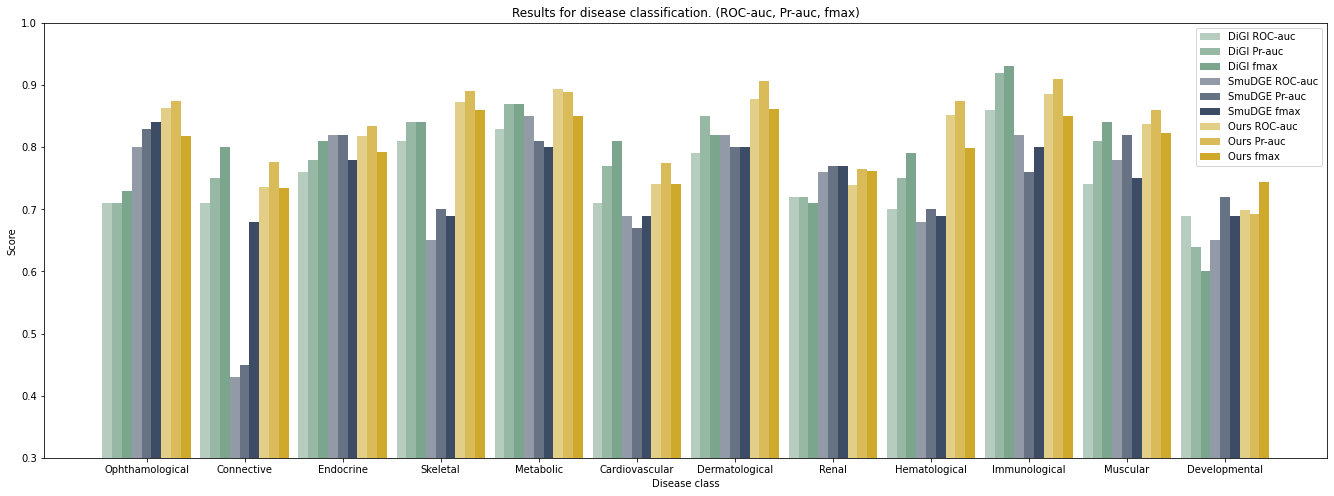

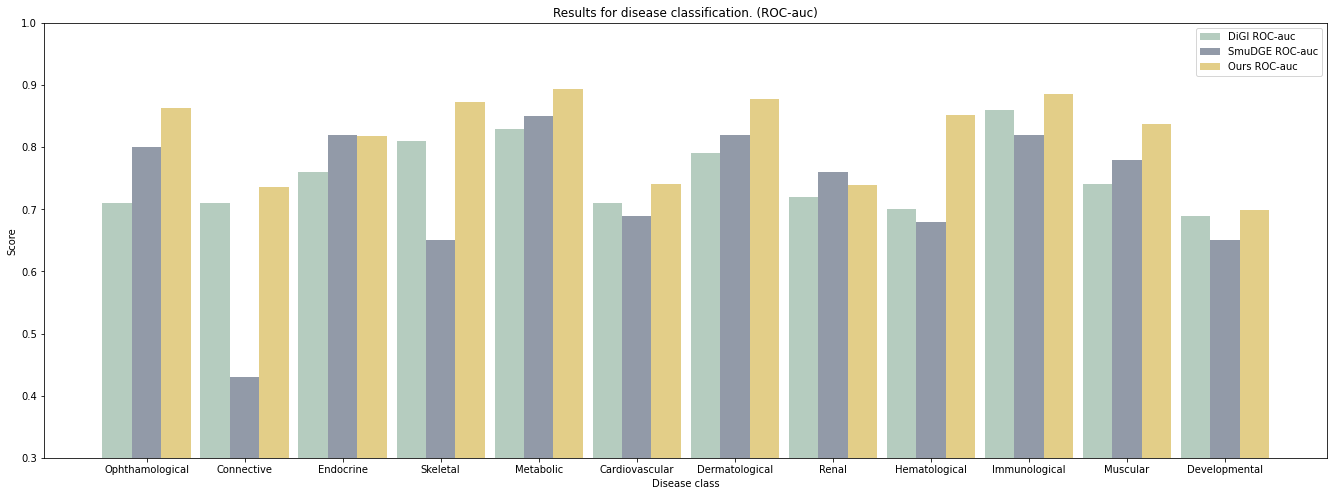

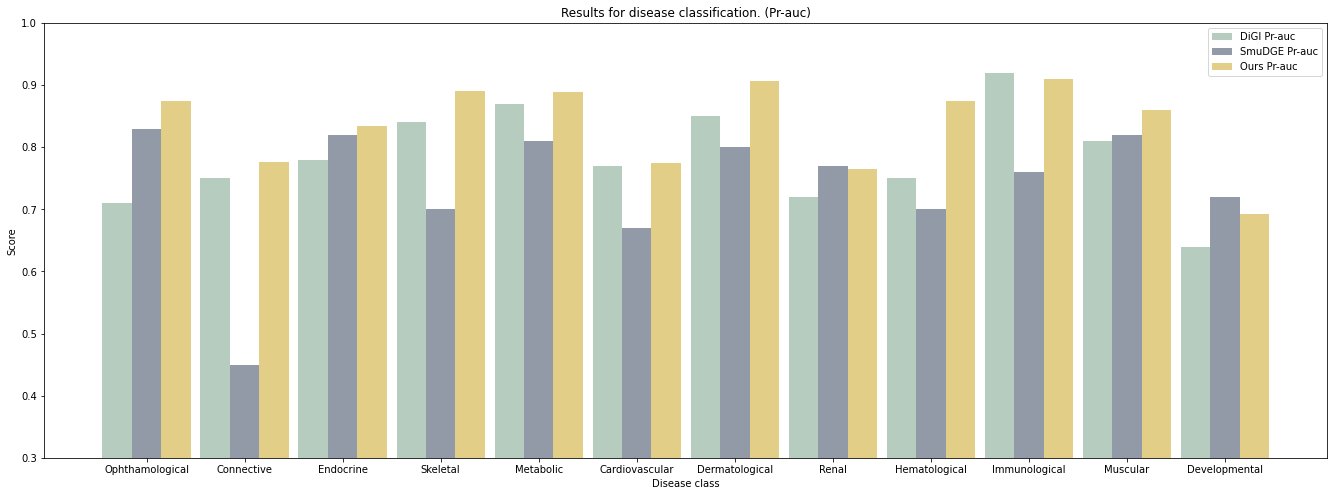

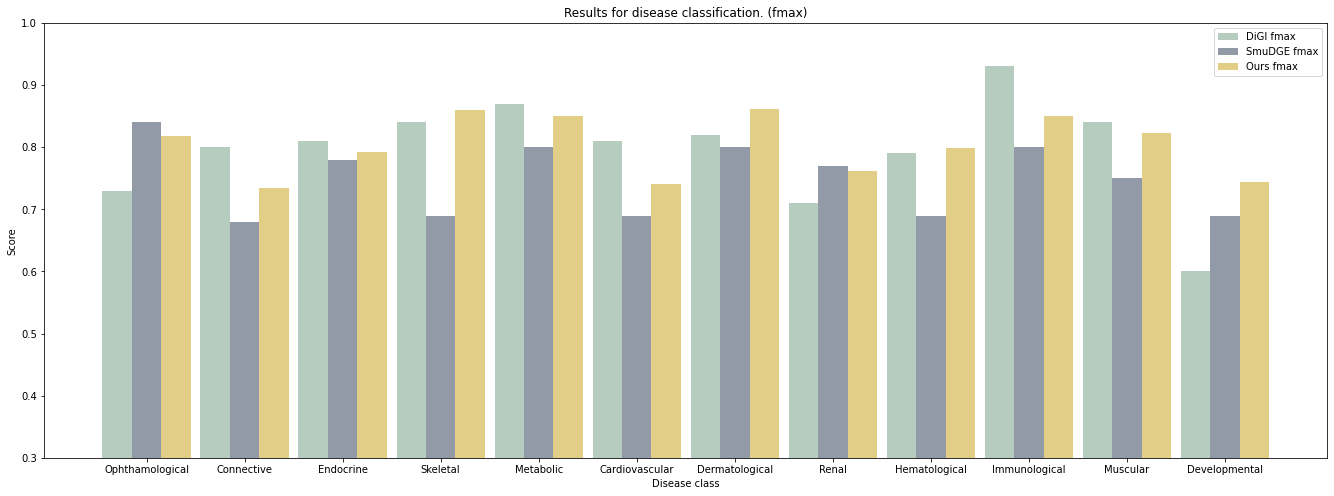

In [16]:
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

results = {
    'DiGI': {
        'ROC-auc': [0.71, 0.71, 0.76, 0.81, 0.83, 0.71, 0.79, 0.72, 0.70, 0.86, 0.74, 0.69],
        'Pr-auc': [0.71, 0.75, 0.78, 0.84, 0.87, 0.77, 0.85, 0.72, 0.75, 0.92, 0.81, 0.64],
        'fmax': [0.73, 0.80, 0.81, 0.84, 0.87, 0.81, 0.82, 0.71, 0.79, 0.93, 0.84, 0.60]
    },
    'SmuDGE': {
        'ROC-auc': [0.80, 0.43, 0.82, 0.65, 0.85, 0.69, 0.82, 0.76, 0.68, 0.82, 0.78, 0.65],
        'Pr-auc': [0.83, 0.45, 0.82, 0.70, 0.81, 0.67, 0.80, 0.77, 0.70, 0.76, 0.82, 0.72],
        'fmax': [0.84, 0.68, 0.78, 0.69, 0.80, 0.69, 0.80, 0.77, 0.69, 0.80, 0.75, 0.69]
    },
    'Ours': {
        'ROC-auc': ours_roc_auc,
        'Pr-auc': ours_pr_auc,
        'fmax': ours_fmax
    }
}

colors = [
    [0.427450980392156, 0.6078431372549019, 0.5019607843137255, 1],
    [0.149019607843137, 0.2156862745098039, 0.3215686274509804, 1],
    [0.788235294117647, 0.6235294117647059, 0.0745098039215686, 1]
]


def plot_bar_chart(plot_only_metrics, width=0.1):
    plt.figure(figsize=[23, 8])
    ax = plt.gca()
    ax.set(ylim=[0.3, 1])

    X = np.arange(len(results['Ours']['ROC-auc']))

    offset = 0
    for i, (method, metrics) in enumerate(results.items()):
        opacity = 0.5
        for metric_name, metric_values in metrics.items():
            if metric_name in plot_only_metrics:
                color = colors[i]
                color[-1] = opacity
                plt.bar(X + offset, metric_values, color=color, width=width)
                opacity += 0.2
                offset += width

    legends = [f'{method} {metric}' for method in results.keys() for metric in results[method].keys() if metric in plot_only_metrics]
    plt.legend(legends, loc='upper right')

    # Overiding the x axis ticks with the disease names
    tick_offset = (3*len(plot_only_metrics) - 1)*width/2
    plt.xticks(
        [i + tick_offset for i in range(len(disease_classes))],
        disease_classes
    )
    plt.title('Results for disease classification. ({})'.format(', '.join(plot_only_metrics)))
    plt.xlabel('Disease class')
    plt.ylabel('Score')
    plt.savefig(
        osp.join(RESULTS_STORAGE, 'disease_gene_classification_result_bar_chart_{}.pdf'.format('_'.join(plot_only_metrics)))
    )
    plt.show()

plot_bar_chart(plot_only_metrics=['ROC-auc', 'Pr-auc', 'fmax'], width=0.1)
plot_bar_chart(plot_only_metrics=['ROC-auc'], width=0.3)
plot_bar_chart(plot_only_metrics=['Pr-auc'], width=0.3)
plot_bar_chart(plot_only_metrics=['fmax'], width=0.3)